<a href="https://colab.research.google.com/github/Samuelaidoo10033/zero-day-network-anomaly-detection/blob/main/ZeroDay_IoT_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# === Step 1: Clean Install & Imports ===

!pip -q install tensorflow==2.19.0 scikit-learn pandas numpy matplotlib > /dev/null

import os, random, math, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.ensemble import IsolationForest
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display, HTML, Markdown

# Repro
RNG = 42
np.random.seed(RNG); random.seed(RNG); tf.random.set_seed(RNG)



In [20]:
# === Step 2: Upload Dataset ===
from google.colab import files
print("Please upload BOTH CSV files: UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv")
uploaded = files.upload()

train_path = "UNSW_NB15_training-set.csv"
test_path  = "UNSW_NB15_testing-set.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)


Please upload BOTH CSV files: UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv


Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set.csv
Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv


In [21]:
# === Step 3: Preprocessing & Zero-Day Split ===

# Drop ID if present
for df in (train_df, test_df):
    if 'id' in df.columns:
        df.drop(columns=['id'], inplace=True)

# Keep numeric features only
drop_cols = [c for c in ['proto','service','state','attack_cat','label'] if c in train_df.columns]
num_cols  = [c for c in train_df.columns if c not in drop_cols]

X_train_num = train_df[num_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0)
X_test_num  = test_df[num_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0)

y_train = train_df['label'].values
y_test  = test_df['label'].values

# Zero-day: train only on benign
X_train_benign = X_train_num[y_train == 0].copy()

MAX_BENIGN_AE  = 80000
MAX_BENIGN_IF  = 20000

X_train_benign_for_ae = X_train_benign.sample(min(len(X_train_benign), MAX_BENIGN_AE), random_state=42)
X_train_benign_for_if = X_train_benign.sample(min(len(X_train_benign), MAX_BENIGN_IF), random_state=42)

scaler = StandardScaler()
X_train_benign_s_ae = scaler.fit_transform(X_train_benign_for_ae)
X_test_s            = scaler.transform(X_test_num)
X_train_benign_s_if = scaler.transform(X_train_benign_for_if)

print("Numeric features:", len(num_cols))
print("Benign train for AE:", X_train_benign_s_ae.shape)
print("Benign train for IF:", X_train_benign_s_if.shape)
print("Test all samples   :", X_test_s.shape)


Numeric features: 39
Benign train for AE: (56000, 39)
Benign train for IF: (20000, 39)
Test all samples   : (82332, 39)


### Isolation Forest — Classification Report

,precision,recall,f1-score,support
0,0.509423,0.933676,0.659187,37000.000000
1,0.830968,0.266125,0.403141,45332.000000
accuracy,0.566123,0.566123,0.566123,0.566123
macro avg,0.670196,0.599901,0.531164,82332.000000
weighted avg,0.686466,0.566123,0.518208,82332.000000


ROC-AUC: 0.7472 | PR-AUC: 0.7607


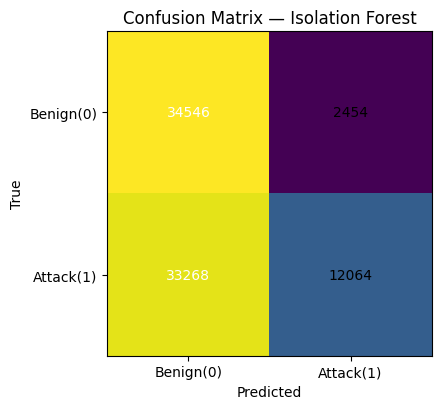

In [22]:
# === Step 4: Isolation Forest (Benign-only training) ===

iso = IsolationForest(
    n_estimators=200,
    max_samples=256,
    contamination='auto',
    random_state=RNG,
    n_jobs=-1
)
iso.fit(X_train_benign_s_if)

# Predict: IF returns {1=inlier, -1=outlier}; attack=1 means outlier
pred_if_raw = iso.predict(X_test_s)
y_pred_if   = (pred_if_raw == -1).astype(int)
scores_if   = -iso.score_samples(X_test_s)  # higher = more anomalous

# Metrics
report_if_dict = classification_report(y_test, y_pred_if, output_dict=True, digits=3, zero_division=0)
report_if_df   = pd.DataFrame(report_if_dict).transpose()
roc_if = roc_auc_score(y_test, scores_if)
pr_if  = average_precision_score(y_test, scores_if)

display(Markdown("### Isolation Forest — Classification Report"))
display(report_if_df)
print(f"ROC-AUC: {roc_if:.4f} | PR-AUC: {pr_if:.4f}")

# Confusion Matrix plot
cm_if = confusion_matrix(y_test, y_pred_if)

plt.figure(figsize=(4.8,4.2))
plt.imshow(cm_if, interpolation='nearest')
plt.title('Confusion Matrix — Isolation Forest'); plt.xlabel('Predicted'); plt.ylabel('True')
ticks = np.arange(2)
plt.xticks(ticks, ['Benign(0)','Attack(1)']); plt.yticks(ticks, ['Benign(0)','Attack(1)'])
thr = cm_if.max() / 2.0
for i in range(cm_if.shape[0]):
    for j in range(cm_if.shape[1]):
        plt.text(j, i, f"{cm_if[i,j]}", ha="center", va="center",
                 color="white" if cm_if[i,j] > thr else "black")
plt.tight_layout()
plt.show()


### Autoencoder — Classification Report

,precision,recall,f1-score,support
0,0.704251,0.903973,0.791711,37000.000000
1,0.898017,0.690153,0.780482,45332.000000
accuracy,0.786244,0.786244,0.786244,0.786244
macro avg,0.801134,0.797063,0.786096,82332.000000
weighted avg,0.810938,0.786244,0.785528,82332.000000


ROC-AUC: 0.8742 | PR-AUC: 0.8986


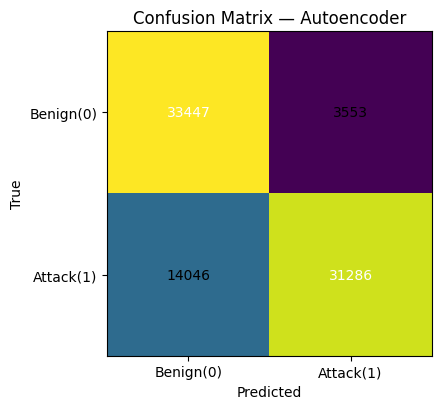

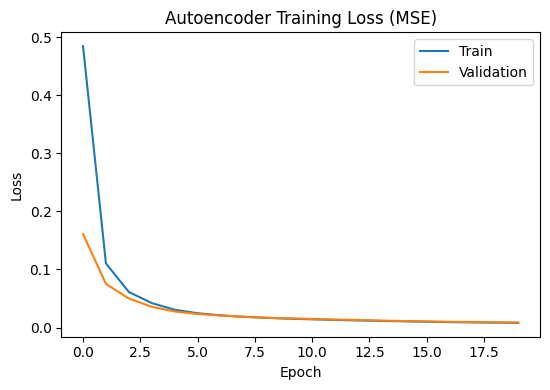

In [23]:
# === Step 5: Autoencoder (Benign-only training) ===

input_dim = X_train_benign_s_ae.shape[1]
enc_units = [128, 64, 32]
dec_units = [64, 128]

inputs = keras.Input(shape=(input_dim,))
x = inputs
for u in enc_units:
    x = layers.Dense(u, activation='relu')(x)
latent = layers.Dense(16, activation='relu')(x)

x = latent
for u in dec_units:
    x = layers.Dense(u, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)

ae = keras.Model(inputs, outputs, name="AE")
ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

history = ae.fit(
    X_train_benign_s_ae, X_train_benign_s_ae,
    validation_split=0.1,
    epochs=20, batch_size=512, verbose=0
)

# AE reconstruction error on TEST
recon_test = ae.predict(X_test_s, batch_size=1024, verbose=0)
mse_test   = np.mean((X_test_s - recon_test)**2, axis=1)

# Threshold from benign train (95th percentile)
recon_train = ae.predict(X_train_benign_s_ae, batch_size=1024, verbose=0)
mse_train   = np.mean((X_train_benign_s_ae - recon_train)**2, axis=1)
thr_ae      = np.percentile(mse_train, 95)

y_pred_ae   = (mse_test > thr_ae).astype(int)

# Metrics
report_ae_dict = classification_report(y_test, y_pred_ae, output_dict=True, digits=3, zero_division=0)
report_ae_df   = pd.DataFrame(report_ae_dict).transpose()
roc_ae = roc_auc_score(y_test, mse_test)
pr_ae  = average_precision_score(y_test, mse_test)

display(Markdown("### Autoencoder — Classification Report"))
display(report_ae_df)
print(f"ROC-AUC: {roc_ae:.4f} | PR-AUC: {pr_ae:.4f}")

# Confusion Matrix
cm_ae = confusion_matrix(y_test, y_pred_ae)
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm_ae, interpolation='nearest')
plt.title('Confusion Matrix — Autoencoder'); plt.xlabel('Predicted'); plt.ylabel('True')
ticks = np.arange(2)
plt.xticks(ticks, ['Benign(0)','Attack(1)']); plt.yticks(ticks, ['Benign(0)','Attack(1)'])
thr = cm_ae.max()/2.0
for i in range(cm_ae.shape[0]):
    for j in range(cm_ae.shape[1]):
        plt.text(j, i, f"{cm_ae[i,j]}", ha="center", va="center",
                 color="white" if cm_ae[i,j] > thr else "black")
plt.tight_layout()
plt.show()

# AE Training Loss Curve (visible inline)
plt.figure(figsize=(5.6,4.0))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Autoencoder Training Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.show()


### Fused (IF + AE) — Classification Report

,precision,recall,f1-score,support
0,0.730708,0.579135,0.646152,37000.000000
1,0.706227,0.825796,0.761346,45332.000000
accuracy,0.714947,0.714947,0.714947,0.714947
macro avg,0.718468,0.702466,0.703749,82332.000000
weighted avg,0.717229,0.714947,0.709578,82332.000000


ROC-AUC: 0.7686 | PR-AUC: 0.7959


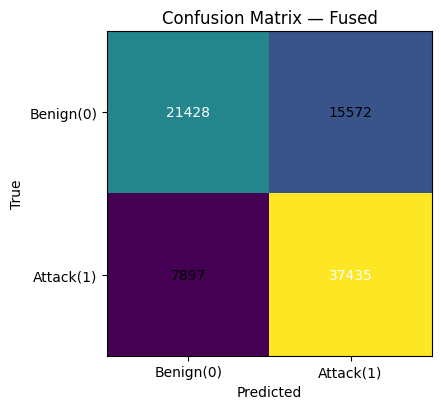

In [24]:
# === Step 6: Score-Level Fusion (IF + AE) ===

def minmax01(a):
    lo, hi = np.percentile(a, 1), np.percentile(a, 99)
    a = np.clip(a, lo, hi)
    return (a - a.min()) / (a.max() - a.min() + 1e-9)

fs_if = minmax01(scores_if)
fs_ae = minmax01(mse_test)
fused = 0.5*fs_if + 0.5*fs_ae

# Threshold via Youden’s J (post-hoc analysis)
fpr, tpr, thr = roc_curve(y_test, fused)
j = tpr - fpr
thr_fused = thr[np.argmax(j)]
y_pred_fused = (fused >= thr_fused).astype(int)

report_fused_dict = classification_report(y_test, y_pred_fused, output_dict=True, digits=3, zero_division=0)
report_fused_df   = pd.DataFrame(report_fused_dict).transpose()
roc_fused = roc_auc_score(y_test, fused)
pr_fused  = average_precision_score(y_test, fused)

display(Markdown("### Fused (IF + AE) — Classification Report"))
display(report_fused_df)
print(f"ROC-AUC: {roc_fused:.4f} | PR-AUC: {pr_fused:.4f}")

# Confusion Matrix
cm_fused = confusion_matrix(y_test, y_pred_fused)
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm_fused, interpolation='nearest')
plt.title('Confusion Matrix — Fused'); plt.xlabel('Predicted'); plt.ylabel('True')
ticks = np.arange(2)
plt.xticks(ticks, ['Benign(0)','Attack(1)']); plt.yticks(ticks, ['Benign(0)','Attack(1)'])
thr = cm_fused.max()/2.0
for i in range(cm_fused.shape[0]):
    for j in range(cm_fused.shape[1]):
        plt.text(j, i, f"{cm_fused[i,j]}", ha="center", va="center",
                 color="white" if cm_fused[i,j] > thr else "black")
plt.tight_layout()
plt.show()


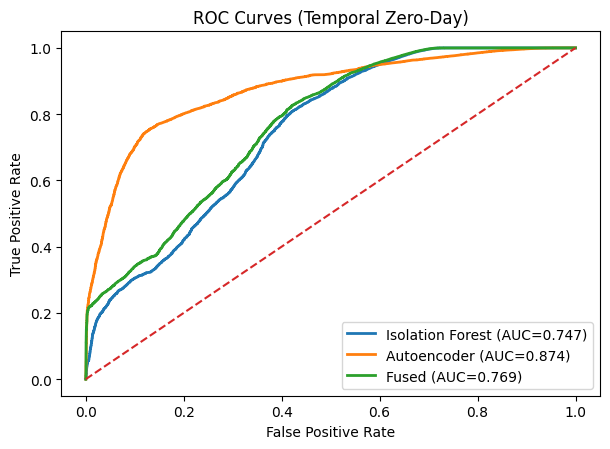

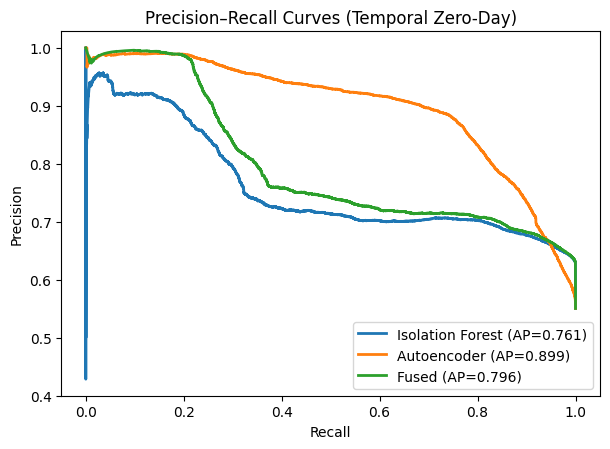

In [25]:
# === Step 7: ROC & PR Curves (All Models) ===

plt.figure(figsize=(6.2,4.6))
for s, lab, auc in [
    (scores_if, "Isolation Forest", roc_if),
    (mse_test,  "Autoencoder",      roc_ae),
    (fused,     "Fused",            roc_fused),
]:
    fpr, tpr, _ = roc_curve(y_test, s)
    plt.plot(fpr, tpr, label=f"{lab} (AUC={auc:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves (Temporal Zero-Day)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.2,4.6))
for s, lab, ap in [
    (scores_if, "Isolation Forest", pr_if),
    (mse_test,  "Autoencoder",      pr_ae),
    (fused,     "Fused",            pr_fused),
]:
    p, r, _ = precision_recall_curve(y_test, s)
    plt.plot(r, p, label=f"{lab} (AP={ap:.3f})", linewidth=2)
plt.title("Precision–Recall Curves (Temporal Zero-Day)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# === Step 8: Results Table ===

results_df = pd.DataFrame([
    ["Isolation Forest", roc_if, pr_if],
    ["Autoencoder",      roc_ae, pr_ae],
    ["Fused",            roc_fused, pr_fused],
], columns=["Model", "ROC-AUC", "PR-AUC"]).round(4)

display(Markdown("### Final Results Table"))
display(results_df)


### Final Results Table

,Model,ROC-AUC,PR-AUC
0,Isolation Forest,0.7472,0.7607
1,Autoencoder,0.8742,0.8986
2,Fused,0.7686,0.7959
